In [56]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
# if con colab
#!unzip /content/Pokemon.zip -d /

In [58]:
project_name = 'pokenon_gan'

In [59]:
DATA_DIR = '/Pokemon'

In [60]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [61]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [62]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [63]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=1, pin_memory=True)

In [64]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

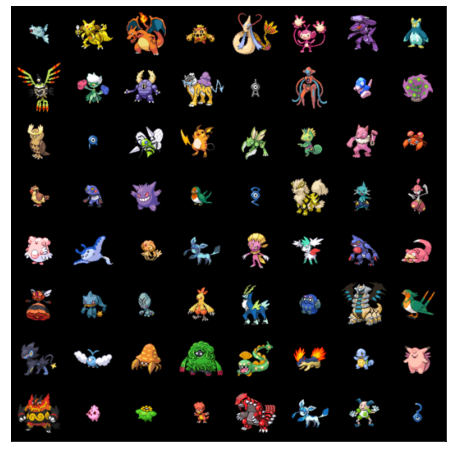

In [65]:
show_batch(train_dl)

In [66]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [67]:
device = get_default_device()
device

device(type='cuda')

In [68]:
train_dl = DeviceDataLoader(train_dl, device)

In [69]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())


In [70]:
x = torch.rand(1, 3, image_size, image_size)
discriminator(x).size()

torch.Size([1, 1])

In [71]:
discriminator = to_device(discriminator, device)

In [72]:
latent_size = 128

In [73]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4,
                       stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)


In [74]:
x = torch.randn(1, latent_size, 1, 1)
x.size()

generator(x).size()

torch.Size([1, 3, 64, 64])

torch.Size([128, 3, 64, 64])


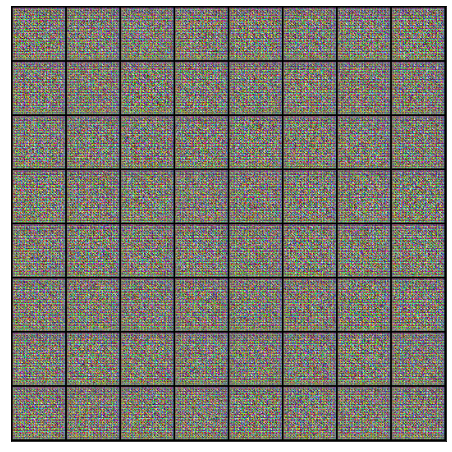

In [75]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors # with pi?
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [76]:
generator = to_device(generator, device)

In [77]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()
    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score # correggere con la % di beccate

In [78]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [79]:
sample_dir = '../results/generated'
os.makedirs(sample_dir, exist_ok=True)

In [80]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [81]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


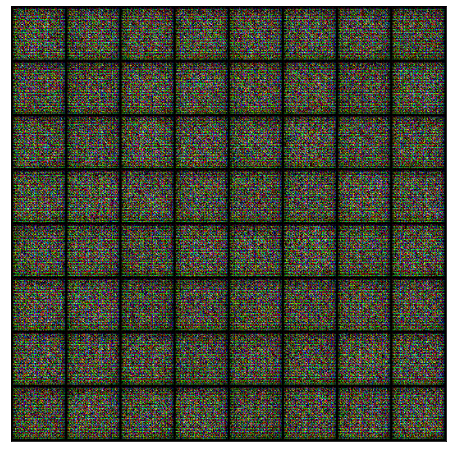

In [82]:
save_samples(0, fixed_latent)

In [83]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in tqdm(range(epochs)):
        for real_images, _ in train_dl:
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        #print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [84]:
lr = 1e-4
epochs = 100
# scheduler?

In [85]:
history = fit(epochs, lr)

  1%|          | 1/100 [00:03<05:58,  3.63s/it]

Saving generated-images-0001.png


  2%|▏         | 2/100 [00:07<05:52,  3.60s/it]

Saving generated-images-0002.png


  3%|▎         | 3/100 [00:10<05:49,  3.60s/it]

Saving generated-images-0003.png


  4%|▍         | 4/100 [00:14<05:48,  3.63s/it]

Saving generated-images-0004.png


  5%|▌         | 5/100 [00:18<05:44,  3.63s/it]

Saving generated-images-0005.png


  6%|▌         | 6/100 [00:21<05:40,  3.63s/it]

Saving generated-images-0006.png


  7%|▋         | 7/100 [00:25<05:35,  3.60s/it]

Saving generated-images-0007.png


  8%|▊         | 8/100 [00:28<05:28,  3.57s/it]

Saving generated-images-0008.png


  9%|▉         | 9/100 [00:32<05:22,  3.55s/it]

Saving generated-images-0009.png


 10%|█         | 10/100 [00:35<05:16,  3.52s/it]

Saving generated-images-0010.png


 11%|█         | 11/100 [00:39<05:11,  3.50s/it]

Saving generated-images-0011.png


 12%|█▏        | 12/100 [00:42<05:06,  3.48s/it]

Saving generated-images-0012.png


 13%|█▎        | 13/100 [00:46<05:01,  3.47s/it]

Saving generated-images-0013.png


 14%|█▍        | 14/100 [00:49<04:56,  3.45s/it]

Saving generated-images-0014.png


 15%|█▌        | 15/100 [00:52<04:52,  3.44s/it]

Saving generated-images-0015.png


 16%|█▌        | 16/100 [00:56<04:48,  3.43s/it]

Saving generated-images-0016.png


 17%|█▋        | 17/100 [00:59<04:44,  3.43s/it]

Saving generated-images-0017.png


 18%|█▊        | 18/100 [01:03<04:40,  3.42s/it]

Saving generated-images-0018.png


 19%|█▉        | 19/100 [01:06<04:37,  3.42s/it]

Saving generated-images-0019.png


 20%|██        | 20/100 [01:10<04:34,  3.43s/it]

Saving generated-images-0020.png


 21%|██        | 21/100 [01:13<04:31,  3.43s/it]

Saving generated-images-0021.png


 22%|██▏       | 22/100 [01:16<04:29,  3.45s/it]

Saving generated-images-0022.png


 23%|██▎       | 23/100 [01:20<04:26,  3.46s/it]

Saving generated-images-0023.png


 24%|██▍       | 24/100 [01:23<04:24,  3.47s/it]

Saving generated-images-0024.png


 25%|██▌       | 25/100 [01:27<04:21,  3.48s/it]

Saving generated-images-0025.png


 26%|██▌       | 26/100 [01:30<04:18,  3.50s/it]

Saving generated-images-0026.png


 27%|██▋       | 27/100 [01:34<04:15,  3.51s/it]

Saving generated-images-0027.png


 28%|██▊       | 28/100 [01:38<04:13,  3.52s/it]

Saving generated-images-0028.png


 29%|██▉       | 29/100 [01:41<04:09,  3.52s/it]

Saving generated-images-0029.png


 30%|███       | 30/100 [01:45<04:06,  3.52s/it]

Saving generated-images-0030.png


 31%|███       | 31/100 [01:48<04:03,  3.53s/it]

Saving generated-images-0031.png


 32%|███▏      | 32/100 [01:52<04:00,  3.53s/it]

Saving generated-images-0032.png


 33%|███▎      | 33/100 [01:55<03:56,  3.53s/it]

Saving generated-images-0033.png


 34%|███▍      | 34/100 [01:59<03:52,  3.53s/it]

Saving generated-images-0034.png


 35%|███▌      | 35/100 [02:02<03:49,  3.54s/it]

Saving generated-images-0035.png


 36%|███▌      | 36/100 [02:06<03:48,  3.57s/it]

Saving generated-images-0036.png


 37%|███▋      | 37/100 [02:09<03:43,  3.55s/it]

Saving generated-images-0037.png


 38%|███▊      | 38/100 [02:13<03:39,  3.54s/it]

Saving generated-images-0038.png


 39%|███▉      | 39/100 [02:17<03:40,  3.61s/it]

Saving generated-images-0039.png


 40%|████      | 40/100 [02:21<03:43,  3.72s/it]

Saving generated-images-0040.png


 41%|████      | 41/100 [02:25<03:54,  3.97s/it]

Saving generated-images-0041.png


 42%|████▏     | 42/100 [02:29<03:53,  4.03s/it]

Saving generated-images-0042.png


 43%|████▎     | 43/100 [02:34<03:51,  4.06s/it]

Saving generated-images-0043.png


 44%|████▍     | 44/100 [02:37<03:43,  3.99s/it]

Saving generated-images-0044.png


 45%|████▌     | 45/100 [02:41<03:31,  3.85s/it]

Saving generated-images-0045.png


 46%|████▌     | 46/100 [02:44<03:22,  3.75s/it]

Saving generated-images-0046.png


 47%|████▋     | 47/100 [02:48<03:14,  3.68s/it]

Saving generated-images-0047.png


 48%|████▊     | 48/100 [02:52<03:11,  3.67s/it]

Saving generated-images-0048.png


 49%|████▉     | 49/100 [02:55<03:07,  3.67s/it]

Saving generated-images-0049.png


 50%|█████     | 50/100 [02:59<03:01,  3.63s/it]

Saving generated-images-0050.png


 51%|█████     | 51/100 [03:02<02:56,  3.61s/it]

Saving generated-images-0051.png


 52%|█████▏    | 52/100 [03:06<02:51,  3.58s/it]

Saving generated-images-0052.png


 53%|█████▎    | 53/100 [03:10<02:49,  3.61s/it]

Saving generated-images-0053.png


 54%|█████▍    | 54/100 [03:13<02:46,  3.62s/it]

Saving generated-images-0054.png


 55%|█████▌    | 55/100 [03:17<02:41,  3.59s/it]

Saving generated-images-0055.png


 56%|█████▌    | 56/100 [03:20<02:37,  3.58s/it]

Saving generated-images-0056.png


 57%|█████▋    | 57/100 [03:24<02:33,  3.57s/it]

Saving generated-images-0057.png


 58%|█████▊    | 58/100 [03:28<02:31,  3.61s/it]

Saving generated-images-0058.png


 59%|█████▉    | 59/100 [03:31<02:26,  3.57s/it]

Saving generated-images-0059.png


 60%|██████    | 60/100 [03:35<02:24,  3.61s/it]

Saving generated-images-0060.png


 61%|██████    | 61/100 [03:38<02:22,  3.64s/it]

Saving generated-images-0061.png


 62%|██████▏   | 62/100 [03:42<02:16,  3.60s/it]

Saving generated-images-0062.png


 63%|██████▎   | 63/100 [03:45<02:11,  3.57s/it]

Saving generated-images-0063.png


 64%|██████▍   | 64/100 [03:49<02:07,  3.54s/it]

Saving generated-images-0064.png


 65%|██████▌   | 65/100 [03:52<02:03,  3.52s/it]

Saving generated-images-0065.png


 66%|██████▌   | 66/100 [03:56<01:59,  3.51s/it]

Saving generated-images-0066.png


 67%|██████▋   | 67/100 [03:59<01:55,  3.50s/it]

Saving generated-images-0067.png


 68%|██████▊   | 68/100 [04:03<01:52,  3.50s/it]

Saving generated-images-0068.png


 69%|██████▉   | 69/100 [04:06<01:48,  3.50s/it]

Saving generated-images-0069.png


 70%|███████   | 70/100 [04:10<01:45,  3.51s/it]

Saving generated-images-0070.png


 71%|███████   | 71/100 [04:13<01:41,  3.50s/it]

Saving generated-images-0071.png


 72%|███████▏  | 72/100 [04:17<01:38,  3.51s/it]

Saving generated-images-0072.png


 73%|███████▎  | 73/100 [04:20<01:34,  3.50s/it]

Saving generated-images-0073.png


 74%|███████▍  | 74/100 [04:24<01:30,  3.50s/it]

Saving generated-images-0074.png


 75%|███████▌  | 75/100 [04:27<01:27,  3.50s/it]

Saving generated-images-0075.png


 76%|███████▌  | 76/100 [04:31<01:23,  3.50s/it]

Saving generated-images-0076.png


 77%|███████▋  | 77/100 [04:34<01:20,  3.50s/it]

Saving generated-images-0077.png


 78%|███████▊  | 78/100 [04:38<01:17,  3.50s/it]

Saving generated-images-0078.png


 79%|███████▉  | 79/100 [04:41<01:13,  3.51s/it]

Saving generated-images-0079.png


 80%|████████  | 80/100 [04:45<01:10,  3.50s/it]

Saving generated-images-0080.png


 81%|████████  | 81/100 [04:48<01:06,  3.50s/it]

Saving generated-images-0081.png


 82%|████████▏ | 82/100 [04:52<01:03,  3.50s/it]

Saving generated-images-0082.png


 83%|████████▎ | 83/100 [04:55<00:59,  3.51s/it]

Saving generated-images-0083.png


 84%|████████▍ | 84/100 [04:59<00:56,  3.51s/it]

Saving generated-images-0084.png


 85%|████████▌ | 85/100 [05:02<00:52,  3.50s/it]

Saving generated-images-0085.png


 86%|████████▌ | 86/100 [05:06<00:48,  3.50s/it]

Saving generated-images-0086.png


 87%|████████▋ | 87/100 [05:09<00:45,  3.50s/it]

Saving generated-images-0087.png


 88%|████████▊ | 88/100 [05:13<00:41,  3.50s/it]

Saving generated-images-0088.png


 89%|████████▉ | 89/100 [05:16<00:38,  3.50s/it]

Saving generated-images-0089.png


 90%|█████████ | 90/100 [05:20<00:35,  3.54s/it]

Saving generated-images-0090.png


 91%|█████████ | 91/100 [05:23<00:31,  3.53s/it]

Saving generated-images-0091.png


 92%|█████████▏| 92/100 [05:27<00:28,  3.57s/it]

Saving generated-images-0092.png


 93%|█████████▎| 93/100 [05:31<00:25,  3.66s/it]

Saving generated-images-0093.png


 94%|█████████▍| 94/100 [05:35<00:21,  3.62s/it]

Saving generated-images-0094.png


 95%|█████████▌| 95/100 [05:38<00:18,  3.63s/it]

Saving generated-images-0095.png


 96%|█████████▌| 96/100 [05:42<00:14,  3.65s/it]

Saving generated-images-0096.png


 97%|█████████▋| 97/100 [05:46<00:10,  3.66s/it]

Saving generated-images-0097.png


 98%|█████████▊| 98/100 [05:49<00:07,  3.61s/it]

Saving generated-images-0098.png


 99%|█████████▉| 99/100 [05:53<00:03,  3.58s/it]

Saving generated-images-0099.png


100%|██████████| 100/100 [05:56<00:00,  3.57s/it]

Saving generated-images-0100.png


In [86]:
losses_g, losses_d, real_scores, fake_scores = history


In [87]:
from IPython.display import Image

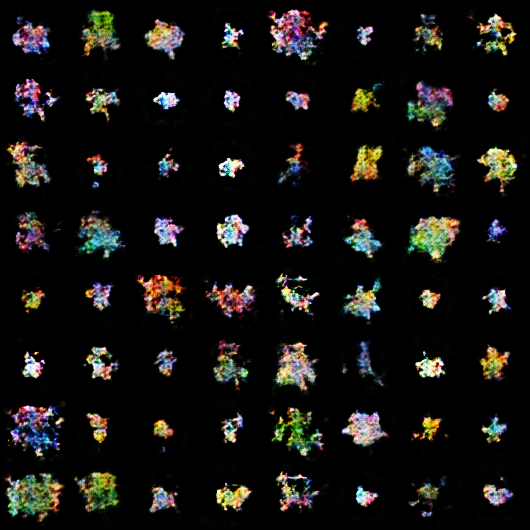

In [88]:
Image('/results/generated/generated-images-0100.png')

In [89]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Text(0.5, 1.0, 'Losses')

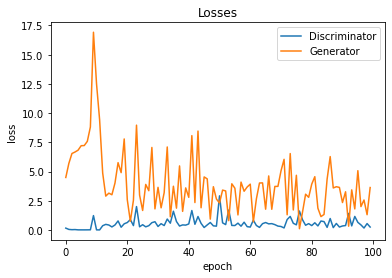

In [90]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

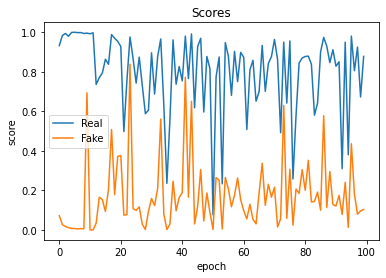

In [92]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


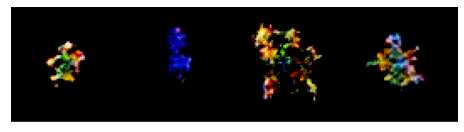

In [107]:
pokemon_egg = to_device(torch.randn(4, latent_size, 1, 1), device)
new_pokemon = generator(pokemon_egg)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(new_pokemon.cpu().detach(), nrow=8).permute(1, 2, 0))